In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from data import *

In [4]:
def unique_centers(centers, idx, nbmires, min_dist = 30): #distance minimale entre deux centres
    """
    Remove centers that are too close to each other.
    
    Arguments :

    centers: list of (x, y) tuples
    min_dist: minimum allowed distance between centers
    idx : list of sorted indexes for centers
    nbmires : number of targets to find

    Returns : list of unique centers
    """
    unique_centers = []
    i = 0
    while len(unique_centers)<nbmires and i<len(idx):
        current_center = centers[idx[i]]

        if all(np.hypot(c[0]-current_center[0], c[1]-current_center[1]) > min_dist for c in unique_centers):
            unique_centers.append(current_center)

        i+=1
    return unique_centers

In [5]:
def mires_template_matching(img_input:np.ndarray, draw = False):
    """Finds the positions of the 8 targets on the unwired PCB, or an error if it could not.

    Arguments :

    img_input - array of pixels : the working image (in BGR)

    draw - bool : whether or not the function should return images of what it is doing.

    Returns : np.ndarray : array of centers
    """
    assert img_input is not None, "file could not be read, check with os.path.exists()" #Vérifier si l'image existe

    template = cv.imread("../ModulePictures/Template_Thresh_cropped.png", cv.IMREAD_GRAYSCALE)

    # Preprocess
    gray = cv.cvtColor(img_input, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    img = cv.medianBlur(gray, 5)

    (height, length) = gray.shape

    ## TODO : changer cette extraction à la main par quelque chose d'automatisé
    sliceparams = [(100, 400, 300, 600, 1),  
                   (-400, -100, 300, 600, 1),
                   (3800, 4200, 500, 800, 2), 
                   (100, 400, -600,-300, 1), 
                   (-400, -100, -600, -300, 1), 
                   (3800, 4200, -800, -500, 2)]

    cimg = cv.cvtColor(img,cv.COLOR_GRAY2BGR) #Avec 3 canaux pour pouvoir l'afficher bien

    centers = []

    for (beg1, end1, beg2, end2, nbmires) in sliceparams :
        mask = img[beg1:end1, beg2:end2]

        #Threshold adaptif
        thr = cv.adaptiveThreshold(
            mask, 255,
            cv.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv.THRESH_BINARY_INV,
            31, 7
        )

        res = cv.matchTemplate(thr,template,cv.TM_CCOEFF_NORMED)
        threshold = 0.6
        loc = np.where( res >= threshold)

        slice_centers = []

        for pt in zip(*loc[::-1]):
            center = (pt[0]+beg2%length + 28, pt[1]+beg1%height + 28) ##NB : Coordonnees du centre dans le template : (28,28)
            slice_centers.append(center)
            if draw:
                cv.circle(cimg, center, 40, (0,0,255), 3)
                cv.circle(cimg,center,2,(0,0,255),3)
        
        #S'il y a plus ou autant de mires que desire, on les regarde quand meme pour choisir les meilleurs matchs et ne pas prendre de doublons
        # On prend les meilleurs matchs
        sorted_idx = np.argsort([res[pt[1], pt[0]] for pt in zip(*loc[::-1])])[::-1]
        slice_centers = unique_centers(slice_centers, sorted_idx, nbmires)
        
        
        # S'il y a moins de slices que prevu, on prévient qu'il y a une erreur TODO changer ces erreurs en l'appel de failsafes avant de se resoudre a une erreur
        if len(slice_centers) < nbmires:
            print(f"Warning : was looking for {nbmires}, found {len(slice_centers)}. Results may be less reliable.")
            cv.imshow("Issue", mask)
            cv.waitKey(0)
            cv.destroyAllWindows()

            if len(slice_centers) == 0:
                slice_centers = [None for _ in range(nbmires)]
            else :
                if slice_centers[0][1] < height//2 : #Si la mire sont dans la partie haute de l'image, on suppose que c'est la mire du haut qui a été trouvée
                    slice_centers += [None] #On met None à la fin de la liste pour la mire du bas
                else : 
                    slice_centers = [None] + slice_centers #On met None au début de la liste pour la mire du haut

        centers.extend(slice_centers)

    if draw :

        for i,(beg1, end1, beg2, end2, _) in enumerate(sliceparams):

            cv.imshow("Mire " + str(i), cimg[beg1:end1, beg2:end2])
            cv.waitKey(0)
            cv.destroyAllWindows()

    return np.array(centers)

In [6]:
mires_template_matching(cv.imread("../ModulePictures/P1005_20UPGM23211816_Reception_Glo_NoLight_AfterClean.jpg"), True)

array([[ 521,  294],
       [ 542, 7660],
       [ 721, 4054],
       [ 721, 3916],
       [7698,  273],
       [7720, 7639],
       [7520, 4033],
       [7519, 3895]])

In [7]:
def compute_homography_center(uncabled_img, cabled_img, crop_ratio=0.4, debug=False):
    """
    Compute homography between uncabled and cabled PCB images by matching ORB features in central region

    Arguments :

    crop_ratio = fraction of width/height to keep around center (0.4 => 40% of the image around the center kept)
    """

    # On convertit en grayscale
    uncbld_gray = cv.cvtColor(uncabled_img, cv.COLOR_BGR2GRAY)
    cbld_gray = cv.cvtColor(cabled_img, cv.COLOR_BGR2GRAY)


    # Extraire la region centrale qu'on veut identifier sur les deux PCB
    def center_crop(img, ratio):
        h, w = img.shape
        kept_h, kept_w = int(h*ratio), int(w*ratio)
        y1, y2 = (h - kept_h)//2, (h + kept_h)//2
        x1, x2 = (w - kept_w)//2, (w + kept_w)//2
        return img[y1:y2, x1:x2], (x1, y1)

    uncbld_crop, offset1 = center_crop(uncbld_gray, crop_ratio)
    cbld_crop, offset2 = center_crop(cbld_gray, crop_ratio)

    orb = cv.ORB_create(nfeatures=3000) #Les features que l'on veut trouver dans cette région centrale

    kp1, des1 = orb.detectAndCompute(uncbld_crop, None)
    kp2, des2 = orb.detectAndCompute(cbld_crop, None)

    #On fait matcher ces descriptions
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)

    # on  conserve les bons matchs
    matches = sorted(matches, key=lambda x: x.distance)
    good = matches[: max(50, len(matches)//3) ]  # on garde le meilleur tiers, avec au moins 50

    if len(good) < 10:
        raise ValueError("Not enough matches in center region to compute homography.")

    #on fait les correspondances
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])

    # Et pour finir on remet ces coordonnees dans l'image entiere non croppee
    pts1[:,0] += offset1[0]
    pts1[:,1] += offset1[1]
    pts2[:,0] += offset2[0]
    pts2[:,1] += offset2[1]

    # on peut alors enfin finir en trouvant l'homographie entre l'image non cablee et l'image cablee !!
    H, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)
    if H is None:
        raise ValueError("Homography computation failed.")

    if debug:
        print("Matches kept:", np.sum(mask))
    
    return H


In [8]:
img_cablee = cv.imread("../ModulePictures/P1004_20UPGM23211223_AfterBonding_NOK.jpg")
img_non_cablee = cv.imread("../ModulePictures/P1004_20UPGM23211223_Reception_Glo_NoLight_AfterClean.jpg")

compute_homography_center(img_non_cablee,img_cablee)

array([[ 6.78901960e-01, -9.05925351e-05,  7.50917800e+02],
       [ 8.54007139e-04,  6.79692664e-01,  2.96011321e+01],
       [ 3.73819906e-08,  3.28441759e-07,  1.00000000e+00]])

In [9]:
def warp_points(points, H):
    """
    Apply homography to an array of N points (x,y)
    """
    pts = np.float32(points).reshape(-1,1,2)
    warped = cv.perspectiveTransform(pts, H)
    return warped.reshape(-1,2)


In [10]:
centres_non_cablee = mires_template_matching(img_non_cablee)
centres_cablee = warp_points(centres_non_cablee, compute_homography_center(img_non_cablee,img_cablee)).astype(int)
print(centres_cablee)

[[1103  225]
 [1113 5219]
 [1237 2684]
 [1237 2778]
 [5974  218]
 [5972 5213]
 [5844 2677]
 [5845 2771]]


In [ ]:
def find_targets_wired(path:str):
    """
    Find the positions of the 8 targets on the wired PCB, or an error if it could not.

    Arguments :

    path - str : path to the image of the wired PCB

    Returns : np.ndarray : array of centers
    """
    cabled_img = cv.imread(path)
    uncabled_img = cv.imread(trouver_la_paire(path, "../ModulePictures"))

    H = compute_homography_center(uncabled_img, cabled_img)

    unwired_centers = mires_template_matching(uncabled_img)
    wired_centers = warp_points(unwired_centers, H).astype(np.int32)

    return wired_centers

In [18]:
find_targets_wired("../ModulePictures/P1004_20UPGM23211223_AfterBonding_NOK.jpg")

Uncabled image path: ../ModulePictures\P1004_20UPGM23211223_Reception_Glo_NoLight_AfterClean.jpg


array([[1103,  225],
       [1113, 5219],
       [1237, 2684],
       [1237, 2778],
       [5974,  218],
       [5972, 5213],
       [5844, 2677],
       [5845, 2771]], dtype=int32)

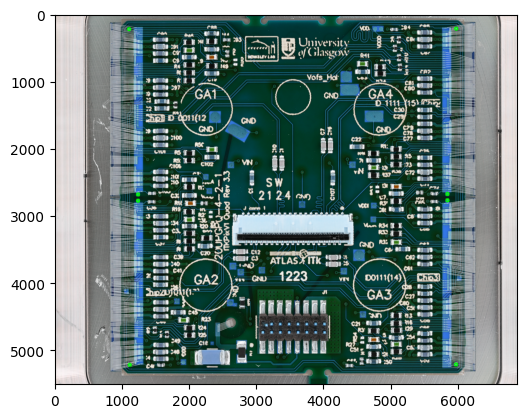

In [11]:
cimg = img_cablee.copy()
for c in centres_cablee :
    cv.circle(cimg,(c[0],c[1]),20,(0,255,0),20)
    cv.circle(cimg,(c[0],c[1]),2,(0,0,255),3)

plt.imshow(cimg)
plt.show()